# 네이버 영화리뷰 감성분석
네이버 영화의 댓글을 모아 구성된 파일  

https://github.com/e9t/nsmc

## 목적
네이버 영화리뷰 감성분석 도전하기

## 데이터 설명
각 파일은 3개의 칼럼으로 구성된다.(id,document,label)
- id : 리뷰 아이디, 네이버 제공
- document : 실제 리뷰
- label : 리뷰의 sentiment 클래스(0:음수,1:양수)
- 컬럼은 'tab'으로 구분되어 있음(tsv 파일 형식. 그러나, 파일 확장명은 .txt이므로 초보자들도 쉽게 다룰 수 있음)
총 20만건의 영화 리뷰
- ratings.txt: 전체 20만 개의 리뷰
- ratings_test.txt: test에 사용할 50,000개의 리뷰
- ratings_train.txt: train에 사용할 15만 개의 리뷰

## 데이터셋 특징
- 모든 리뷰가 140자 미만으로 작성되어 있음
- 각 sentimenet class가 동일하게 표본 추출됨(즉, 랜덤 추출은 50% 정확도를 산출함)
- 10만 개의 부정적 입장의 리뷰(1점-4점에 해당하는 리뷰)
- 10만 개의 긍정적 입장의 리뷰(9점-10점에 해당하는 리뷰)
- 중립적 입장의 리뷰(5점-8점에 해당하는 리뷰)는 제외됨

## 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/AIFFEL_PROJECT/EXPLORATION_7/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/AIFFEL_PROJECT/EXPLORATION_7/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터로더 구성
가공되지 않은 텍스트파일을 자신만의 data_loader() 를 만든다
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화

https://han-py.tistory.com/283

https://wikidocs.net/64517
- 불용어(Stopwords) 제거->인터넷 검색 시 검색 용어로 사용하지 않는 단어. 관사, 전치사, 조사, 접속사 등 검색 색인 단어로 의미가 없는 단어
- 사전 _word_to_index_ 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- _X_train, y_train, X_test, y_test, word_to_index_ 리턴

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
index_to_word = {index:word for word, index in word_to_index.items()}

In [3]:
train_data['document']

0                                       아 더빙.. 진짜 짜증나네요 목소리
1                         흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                             교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
149995                                  인간이 문제지.. 소는 뭔죄인가..
149996                                        평점이 너무 낮아서...
149997                      이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?
149998                          청춘 영화의 최고봉.방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 146183, dtype: object

In [4]:
# Mecab 클래스 예시 
#print(mecab.morphs(u'영등포구청역에 있는 맛집 좀 알려주세요.'))
#>>> ['영등포구', '청역', '에', '있', '는', '맛집', '좀', '알려', '주', '세요', '.']

In [5]:
np.concatenate(X_train).tolist() #tolist()함수를 사용하여 같은 레벨(위치)에 있는 데이터끼리 묶어준다

[32.0,
 74.0,
 919.0,
 4.0,
 4.0,
 39.0,
 228.0,
 20.0,
 33.0,
 748.0,
 1028.0,
 4.0,
 11.0,
 519.0,
 549.0,
 687.0,
 5.0,
 120.0,
 4.0,
 70.0,
 1639.0,
 52.0,
 925.0,
 1006.0,
 15.0,
 44.0,
 391.0,
 24.0,
 205.0,
 2.0,
 8409.0,
 158.0,
 3925.0,
 4.0,
 4.0,
 298.0,
 94.0,
 17.0,
 6.0,
 4.0,
 4.0,
 58.0,
 3479.0,
 2.0,
 8894.0,
 1108.0,
 52.0,
 2832.0,
 60.0,
 5.0,
 14.0,
 2758.0,
 41.0,
 1188.0,
 35.0,
 351.0,
 42.0,
 22.0,
 40.0,
 60.0,
 2.0,
 2.0,
 427.0,
 3102.0,
 1766.0,
 6.0,
 675.0,
 2.0,
 2.0,
 131.0,
 420.0,
 185.0,
 1547.0,
 712.0,
 65.0,
 1694.0,
 715.0,
 53.0,
 375.0,
 192.0,
 271.0,
 5.0,
 4.0,
 69.0,
 4.0,
 11.0,
 2179.0,
 122.0,
 750.0,
 4.0,
 253.0,
 381.0,
 9.0,
 384.0,
 2012.0,
 55.0,
 15.0,
 817.0,
 6.0,
 4.0,
 232.0,
 1450.0,
 144.0,
 6.0,
 425.0,
 756.0,
 2.0,
 2.0,
 52.0,
 1532.0,
 290.0,
 99.0,
 250.0,
 4.0,
 4.0,
 28.0,
 855.0,
 29.0,
 353.0,
 652.0,
 540.0,
 509.0,
 583.0,
 6.0,
 3318.0,
 4.0,
 8895.0,
 22.0,
 1460.0,
 1460.0,
 4.0,
 4.0,
 71.0,
 304.0,
 17.0,
 

In [6]:
df=pd.DataFrame({'value':[1,2,3],'test':['a','b','b']})

In [7]:
df

,value,test
0,1,a
1,2,b
2,3,b


In [8]:
df.values.tolist()

[[1, 'a'], [2, 'b'], [3, 'b']]

In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
print(index_to_word[1]) 

<BOS>


In [11]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 모델구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [12]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

# 패딩 추가
# 가장 마지막 위치의 단어가 state에 가장 많은 영향을 미치므로 padding은 pre로 지정.
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 
(146182, 41)


## 4. 모델구성 및 validation set 구성
- model_1
1-D Convolution Neural Network(1-D CNN) 사용
- model_2 
GlobalMaxPooling1D()레이어 하나만 사용
- model_3
LSTM 레이어 사용

In [13]:
vocab_size = 10000
word_vector_dim = 20

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.

# 1-D Convolution Neural Network(1-D CNN) 사용
model_1 = keras.Sequential()
model_1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_1.add(keras.layers.MaxPooling1D(5))
model_1.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_1.add(keras.layers.GlobalMaxPooling1D())
model_1.add(keras.layers.Dense(8, activation='relu'))
model_1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 20)          200000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          2256      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [14]:

# 학습 데이터 중 20000개를 validation set으로 사용
X_val = X_train[:20000]   
y_val = y_train[:20000]

partial_X_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(126182, 41)
(126182,)


## 5. 모델 훈련 개시

In [15]:
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
247/247 [==============================] - 10s 23ms/step - loss: 0.6035 - accuracy: 0.6321 - val_loss: 0.3513 - val_accuracy: 0.8479
Epoch 2/20
247/247 [==============================] - 2s 9ms/step - loss: 0.3290 - accuracy: 0.8599 - val_loss: 0.3390 - val_accuracy: 0.8542
Epoch 3/20
247/247 [==============================] - 2s 8ms/step - loss: 0.2892 - accuracy: 0.8803 - val_loss: 0.3378 - val_accuracy: 0.8561
Epoch 4/20
247/247 [==============================] - 2s 8ms/step - loss: 0.2529 - accuracy: 0.8991 - val_loss: 0.3441 - val_accuracy: 0.8543
Epoch 5/20
247/247 [==============================] - 2s 8ms/step - loss: 0.2213 - accuracy: 0.9157 - val_loss: 0.3588 - val_accuracy: 0.8526
Epoch 6/20
247/247 [==============================] - 2s 8ms/step - loss: 0.1902 - accuracy: 0.9307 - val_loss: 0.3944 - val_accuracy: 0.8493
Epoch 7/20
247/247 [==============================] - 2s 9ms/step - loss: 0.1559 - accuracy: 0.9459 - val_loss: 0.4230 - val_accuracy: 0.8446
Epoc

In [16]:
results = model_1.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.9987 - accuracy: 0.8163
[0.9987350106239319, 0.8163232207298279]


## 6. Loss, Accuracy 그래프 시각화

In [17]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


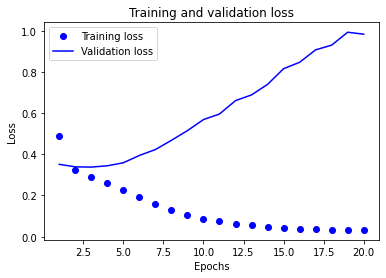

In [18]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

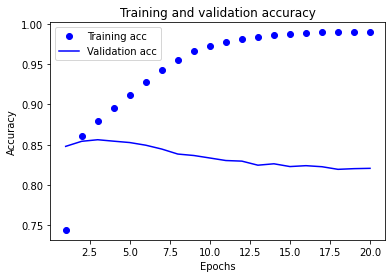

In [19]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7. 학습된 Embedding 레이어 분석

In [20]:
embedding_layer_1 = model_1.layers[0]
weights = embedding_layer_1.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 20)


In [21]:
word2vec_file_path_1 = os.getenv('HOME')+'/aiffel/AIFFEL_PROJECT/EXPLORATION_7/sentiment_classification/word2vec_1.txt'
f = open(word2vec_file_path_1, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

8

In [22]:
vectors = model_1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

### model_2
- 모델구성 및 validation set 구성
- 모델 훈련 개시
- Loss, Accuracy 그래프 시각화
- 학습된 Embedding 레이어 분석

In [23]:
# GlobalMaxPooling1D()레이어 하나만 사용
model_2 = keras.Sequential()
model_2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(keras.layers.GlobalMaxPooling1D())
model_2.add(keras.layers.Dense(8, activation='relu'))
model_2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 20)          200000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 200,177
Trainable params: 200,177
Non-trainable params: 0
_________________________________________________________________


In [24]:
# 학습 데이터 중 20000개를 validation set으로 사용
X_val = X_train[:20000]   
y_val = y_train[:20000]

partial_X_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(126182, 41)
(126182,)


In [25]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
247/247 [==============================] - 2s 6ms/step - loss: 0.6576 - accuracy: 0.6970 - val_loss: 0.4146 - val_accuracy: 0.8260
Epoch 2/20
247/247 [==============================] - 1s 6ms/step - loss: 0.3835 - accuracy: 0.8378 - val_loss: 0.3545 - val_accuracy: 0.8444
Epoch 3/20
247/247 [==============================] - 1s 6ms/step - loss: 0.3217 - accuracy: 0.8658 - val_loss: 0.3465 - val_accuracy: 0.8469
Epoch 4/20
247/247 [==============================] - 1s 6ms/step - loss: 0.2922 - accuracy: 0.8802 - val_loss: 0.3478 - val_accuracy: 0.8485
Epoch 5/20
247/247 [==============================] - 1s 5ms/step - loss: 0.2676 - accuracy: 0.8922 - val_loss: 0.3535 - val_accuracy: 0.8476
Epoch 6/20
247/247 [==============================] - 1s 6ms/step - loss: 0.2526 - accuracy: 0.8999 - val_loss: 0.3609 - val_accuracy: 0.8468
Epoch 7/20
247/247 [==============================] - 1s 6ms/step - loss: 0.2425 - accuracy: 0.9040 - val_loss: 0.3704 - val_accuracy: 0.8450
Epoch 

In [26]:
results = model_2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5524 - accuracy: 0.8257
[0.552376389503479, 0.8257012963294983]


In [27]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


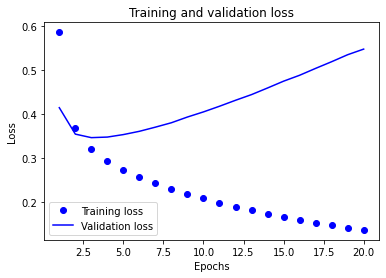

In [28]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

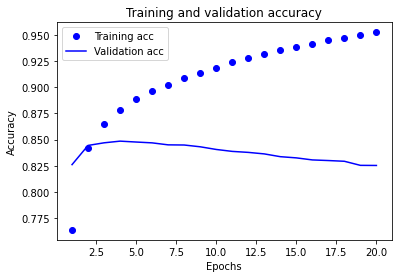

In [29]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [30]:
embedding_layer_2 = model_2.layers[0]
weights = embedding_layer_2.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 20)


In [31]:
word2vec_file_path_2 = os.getenv('HOME')+'/aiffel/AIFFEL_PROJECT/EXPLORATION_7/sentiment_classification/word2vec_2.txt'
f = open(word2vec_file_path_2, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

8

In [32]:
vectors = model_2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

### model_3
- 모델구성 및 validation set 구성
- 모델 훈련 개시
- Loss, Accuracy 그래프 시각화
- 학습된 Embedding 레이어 분석

In [33]:
# LSTM 레이어 사용
model_3 = keras.Sequential()
model_3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_3.add(keras.layers.Dense(8, activation='relu'))
model_3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 20)          200000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 928       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 201,009
Trainable params: 201,009
Non-trainable params: 0
_________________________________________________________________


In [34]:
# 학습 데이터 중 20000개를 validation set으로 사용
X_val = X_train[:20000]   
y_val = y_train[:20000]

partial_X_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(126182, 41)
(126182,)


In [35]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
247/247 [==============================] - 5s 13ms/step - loss: 0.5765 - accuracy: 0.7174 - val_loss: 0.3580 - val_accuracy: 0.8475
Epoch 2/20
247/247 [==============================] - 3s 11ms/step - loss: 0.3339 - accuracy: 0.8607 - val_loss: 0.3519 - val_accuracy: 0.8475
Epoch 3/20
247/247 [==============================] - 3s 11ms/step - loss: 0.3122 - accuracy: 0.8719 - val_loss: 0.3448 - val_accuracy: 0.8496
Epoch 4/20
247/247 [==============================] - 3s 11ms/step - loss: 0.3012 - accuracy: 0.8768 - val_loss: 0.3443 - val_accuracy: 0.8530
Epoch 5/20
247/247 [==============================] - 3s 11ms/step - loss: 0.2901 - accuracy: 0.8811 - val_loss: 0.3461 - val_accuracy: 0.8526
Epoch 6/20
247/247 [==============================] - 3s 11ms/step - loss: 0.2800 - accuracy: 0.8865 - val_loss: 0.3447 - val_accuracy: 0.8515
Epoch 7/20
247/247 [==============================] - 3s 11ms/step - loss: 0.2728 - accuracy: 0.8900 - val_loss: 0.3454 - val_accuracy: 0.8524

In [36]:
results = model_3.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.5060 - accuracy: 0.8428
[0.5060176849365234, 0.8427690863609314]


In [37]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


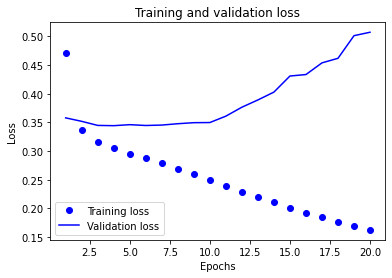

In [38]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

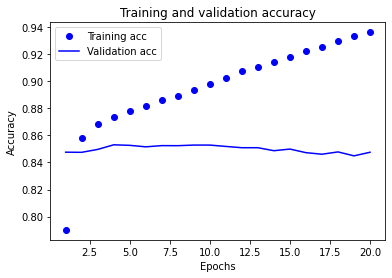

In [39]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [40]:
embedding_layer_3 = model_3.layers[0]
weights = embedding_layer_3.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 20)


In [41]:
word2vec_file_path_3 = os.getenv('HOME')+'/aiffel/AIFFEL_PROJECT/EXPLORATION_7/sentiment_classification/word2vec_3.txt'
f = open(word2vec_file_path_3, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

8

In [42]:
vectors = model_3.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [43]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_3, binary=False)
vector = word_vectors['love']

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [44]:
word_vectors.similar_by_word("love")

[('제니', 0.9877253174781799),
 ('재방송', 0.9874716997146606),
 ('코끝', 0.9873623251914978),
 ('소박', 0.9858189821243286),
 ('타고난', 0.9848430752754211),
 ('견', 0.9846150279045105),
 ('허각', 0.984022855758667),
 ('따스', 0.9838157892227173),
 ('해집니다', 0.9837102890014648),
 ('감회', 0.982576310634613)]

# 결과

- 3가지 모델(GlobalMaxPooling1D, CNN, LSTM) 중 LSTM 모델이 가장 성능이 좋게 나왔다.